In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt

import scipy.signal as scisig

from scipy.signal import butter, filtfilt

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='lowpass')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass')
    return b, a


def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def R2_func(f, y, A):
    return A/y/((f*2*np.pi)**2 + y**2)

In [31]:
base = 'C:/Users/yuhan/nanospheres/Data/Monitoring/240329/Long tts for R2/tt ('
files = [1, 2, 3, 4, 6, 7, 8, 9]
end = ').mat'

In [32]:
def demod_XY(signal, time, demod_freq):
    #t2 = np.linspace(0, len(np.transpose(tt['B'])[0])*tt['Tinterval'][0][0], len(np.transpose(tt['B'])[0]))
    t2 = time
    demod = np.cos(2*np.pi*demod_freq*time)
    demod2 = np.sin(2*np.pi*demod_freq*time)
    X_tt = signal*demod
    Y_tt = signal*demod2
    return t2, X_tt, Y_tt

def demod_RTheta(signal, time, demod_freq, bandwidth):
    t2, X_tt, Y_tt = demod_XY(signal, time, demod_freq)
    X_tt_filt = butter_lowpass_filter(X_tt, bandwidth, int(1/t2[1]), order = 5)
    Y_tt_filt = butter_lowpass_filter(Y_tt, bandwidth, int(1/t2[1]), order = 5)
    R2 = X_tt_filt**2 + Y_tt_filt**2
    theta = np.unwrap(-2*np.arctan(X_tt_filt[1:]/Y_tt_filt[1:]))/2
    R2_filt = butter_lowpass_filter(R2, 100, int(1/t2[1]), order = 2)
    theta_filt = butter_lowpass_filter(theta, 1, int(1/t2[1]), order = 2)
    return t2, R2_filt, theta_filt, R2, theta

In [33]:
PSD_R2z_avr = np.zeros(10000)

for i in files:
    filename = base + str(int(i)) + end
    data = sio.loadmat(filename)
    z = np.transpose(data['C'])[0]
    z_lowpass = butter_lowpass_filter(z, 100000, fs = 10**6, order = 5)
    z_bandpass = butter_highpass_filter(z_lowpass, 30000, fs = 10**6, order = 5)
    #outputs = demod_RTheta(z, np.linspace(0, 100, len(z)), 67000, 3000)
    R2z = z_bandpass**2
    R2z_filt = butter_lowpass_filter(R2z, 100, fs = 10**6, order = 3)
    #R2z_filt = outputs[1]
    PSD_R2z = scisig.welch(R2z_filt, fs = 10**6, nperseg = 100*10**6)
    PSD_R2z_avr += PSD_R2z[1][:10000]
    
PSD_R2z_avr /= len(files)

In [34]:
fitz, covz = opt.curve_fit(R2_func, PSD_R2z[0][:50], PSD_R2z_avr[:50])
fittedz = R2_func(PSD_R2z[0][:1000], *fitz)
print(fitz)
print(1/fitz[0]*5*1000/60/4)

[1.64248333e+00 2.02812413e-15]
12.684045560569947


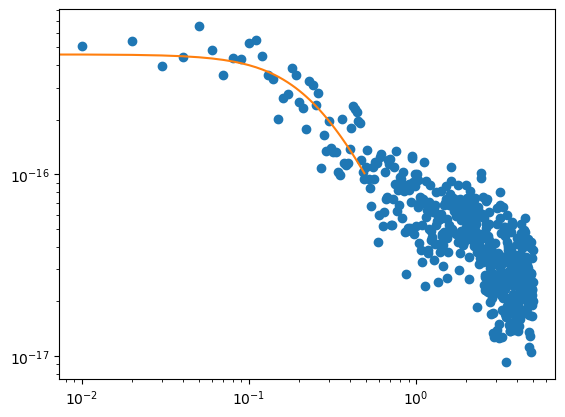

In [39]:
lb = 0
ub = 500
plt.plot(PSD_R2z[0][lb:ub], PSD_R2z_avr[lb:ub], 'o')
plt.plot(PSD_R2z[0][0:50], fittedz[0:50])
plt.yscale('log')
plt.xscale('log')

In [92]:
y_lowpass = butter_lowpass_filter(y, 400000, fs = 10**6, order = 5)
y_bandpass = butter_highpass_filter(y_lowpass, 320000, fs = 10**6, order = 5)
PSD = scisig.welch(y_bandpass, fs = 10**6, nperseg = 10**5)

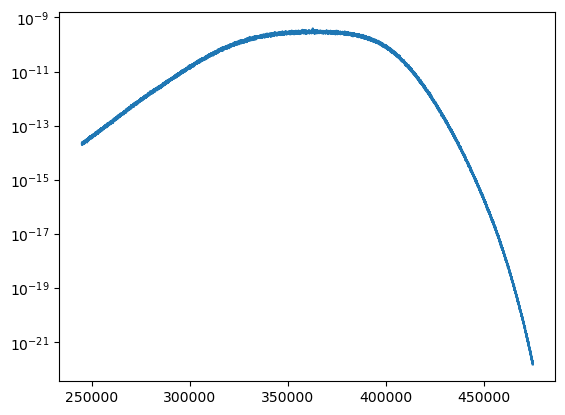

In [93]:
lb = 24500
ub = 47500
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')